In [1]:
#clean up in v02 and run tests
#v03 cleaner
#v04 moving NN's to py file
#v05 testing other models

import pandas as pd
import os
from tqdm import tqdm
import time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, regularizers
from helper_functions.testing_functions import accuracy_distance, accuracy_moneyline, accuracy_ou
from helper_functions.simulate_game import simulate_game
from helper_functions.combine_matrices import combine_team_matrix
from tensorflow.keras.losses import Loss
import seaborn as sns
import pickle
from helper_functions import nn_architectures as nn
from sklearn.ensemble import RandomForestRegressor

In [2]:
def calc_dist(x1,x2,y1,y2):
    return np.sqrt((x1-y1)**2 + (x2-y2)**2)

def calc_ou(x1,x2,y1,y2):
    return (y1+y2) - (x1+x2)

def calc_winner(x1,x2,y1,y2):
    return (x1>x2)==(y1>y2)

def calc_score(data, var='Distance'):
    if var == 'Distance':
        func = np.vectorize(calc_dist)
    elif var == 'OU':
        func=np.vectorize(calc_ou)
    elif var == 'Winner':
        func=np.vectorize(calc_winner)

    result = func(data['Real Home Score'],
                    data['Real Away Score'],
                    data['Projected Home Score'],
                    data['Projected Away Score'])
    return result

In [3]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [4]:
#load game data
with open('ma_list.pickle', 'rb') as file:
    ma_list = pickle.load(file)

with open('mb_list.pickle', 'rb') as file:
    mb_list = pickle.load(file)

with open('output_list.pickle', 'rb') as file:
    output_list = pickle.load(file)

In [5]:
#going to zip these into dicts to access by game ID
game_ids = []
for game in tqdm(os.listdir('raw_game_pulls')):
    game_ids.append(game.split('_')[0])


#FINAL RAW DICTS
team_A_matrices_raw = dict(zip(game_ids, ma_list))
team_B_matrices_raw = dict(zip(game_ids, mb_list))
outputs_raw = dict(zip(game_ids, output_list))

100%|██████████| 5498/5498 [00:00<00:00, 1829455.25it/s]


In [6]:
#transform regular output data into argmax array form
arr_outputs = []
for x in output_list:
    value1, value2 = x

    # Create numpy arrays
    array1 = np.zeros(201)
    array2 = np.zeros(201)

    # Set the corresponding indices to 1
    array1[value1 - 1] = 1
    array2[value2 - 1] = 1 
    arr_outputs.append((array1, array2))

#FINAL ARRAY DICT
outputs_array = dict(zip(game_ids, arr_outputs))

In [7]:
#normalize inputs ###############################################################################

with open('helper_functions/avg_input_matrix.pickle', 'rb') as file:
    avg_df = pickle.load(file)

with open('helper_functions/std_input_matrix.pickle', 'rb') as file:
    std_dev_df = pickle.load(file)

norm_inputs_a = []
norm_inputs_b = []

#Normalize each value in each matrix
for matrix in ma_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_a.append(normalized_matrix)

for matrix in mb_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_b.append(normalized_matrix)


#NORMALIZED MATRIX DICTS
team_A_matrices_normal = dict(zip(game_ids, norm_inputs_a))
team_B_matrices_normal = dict(zip(game_ids, norm_inputs_b))

In [8]:
#load saved simulations into dicts with game ID and 1000 scores
saved_sim_ids = [x.split('.')[0] for x in os.listdir('saved_sims_small')]
simulated_scores = []
for x in  os.listdir('saved_sims_small'):
    with open('saved_sims_small/{}'.format(x), 'rb') as file:
        data=pickle.load(file)
        simulated_scores.append(data)
simulated_scores_dict = dict(zip(saved_sim_ids, simulated_scores))

In [9]:
#train test split on simulated score game IDS 
train_index, test_index = train_test_split(list(simulated_scores_dict.keys()), test_size=0.2)

In [10]:
#matrix_A_train is list of normalized input matrices used for training NN
matrix_A_train = [team_A_matrices_normal[x] for x in train_index]
matrix_B_train = [team_B_matrices_normal[x] for x in train_index]


#y_train is training list of argmax formatted outputs
y_train = [outputs_array[x] for x in train_index]

#matrix_A_test is list of normalized input matrices used for testing NN
matrix_A_test = [team_A_matrices_normal[x] for x in test_index]
matrix_B_test = [team_B_matrices_normal[x] for x in test_index]

#y_test is testing list of argmax formatted outputs
y_test=[outputs_array[x] for x in test_index]

#get testing versions of raw outputs (not for NN testing, just accuracy calcs)
final_scores_test = [outputs_raw[x] for x in test_index]

#do same as above for regular simulation testing - not normalized and no training data needed
simulation_output_test = [simulated_scores_dict[x] for x in test_index]

In [11]:
def test_nn_output(model, game_index, num_sims):
    #Pull and Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[test_index.index(game_index)].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[test_index.index(game_index)].values.reshape(-1, 18, 18)

    predictions = model.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    home_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[0][0])
    away_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[1][0])

    current_df = pd.DataFrame(zip(home_scores, away_scores), columns = ['Home','Away'])
    current_df['Game']=game_index
    return current_df

In [12]:
#variables list

#ALL GAMES:
#team_A_matrices_raw - dict of key: game_id, val: home team matrix
#team_B_matrices_raw - dict of key: game_id, val: away team matrix
#outputs_raw - dict of key: game_id, val: final score tuple
#outputs_array - dict of key: game_id, val: array version of output (one-hot format)
#team_A_matrices_normal - dict of key: game_id, val: normalized home team matrix
#team_B_matrices_normal - dict of key: game_id, val: normalized away team matrix

#saved_sim_ids - list of game IDS in simulated data
#simulated_scores_dict - dict of key: game_id, val: list of 1000 score tuples

#train_index, test_index - lists of game id's for training and testing

#TRAINING GAMES:
#matrix_A_train - list of normalized home team matrices for training
#matrix_B_train - list of normalized away team matrices for training
#y_train - list of one-hot outputs for training

#TESTING GAMES:
#matrix_A_test - list of normalized home team matrices for testing
#matrix_B_test - list of normalized away team matrices for testing
#y_test - list of one-hot outputs for testing

#simulation_output_test - list of 1000 score tuples for testing
#final_scores_test - 

In [13]:
m1 = nn.train_model(nn.nn1, 
                    matrix_A_train, 
                    matrix_B_train, 
                    y_train, 10, 64)

In [14]:
data_list = []
for g in tqdm(range(len(final_scores_test))):
    real_score = final_scores_test[g]
    current_1000 = simulation_output_test[g]
    current_df = pd.DataFrame(current_1000, columns=['Projected Home Score','Projected Away Score'])
    current_df['Game'] = test_index[g]
    current_df['Real Home Score'] = real_score[0]
    current_df['Real Away Score'] = real_score[1]
    data_list.append(current_df)
testing_dataframe = pd.concat(data_list).reset_index(drop=True)

100%|██████████| 1100/1100 [00:05<00:00, 207.41it/s]


In [15]:
testing_dataframe['Distance'] = calc_score(testing_dataframe)
testing_dataframe['OU'] = calc_score(testing_dataframe, 'OU')
testing_dataframe['Winner'] = calc_score(testing_dataframe, 'Winner')
testing_df_grouped = testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()
testing_df_grouped['Correct'] = testing_df_grouped['Winner']>0.5

In [16]:
testing_df_grouped['Correct'].mean()

0.6663636363636364

In [17]:
m2 = nn.train_model(nn.nn1, matrix_A_train, matrix_B_train, y_train, 10, 64)

In [20]:
# Define your random forest regressor function
def rf_regressor():
    # Create a RandomForestRegressor object
    model = RandomForestRegressor(n_estimators=100, max_depth=10, criterion='absolute_error', min_samples_split=5, verbose=True)
    return model

# Define your training function
def train_model(model_function, matrixA_list, matrixB_list, output_tuple_list):
    global X
    global y1, y2
    # Convert lists of arrays to numpy arrays
    matrixA_array = np.array(matrixA_list)
    matrixB_array = np.array(matrixB_list)
    output_array = np.array(output_tuple_list)
    
    # Concatenate along the appropriate axis
    X = np.concatenate((matrixA_array, matrixB_array), axis=1)  # Concatenate along columns
    X_flat = []
    for array in X:
        X_flat.append(array.reshape(-1))  # Reshape and flatten each array
    
    X_flat = np.array(X_flat)
    
    # Reshape outputs for RandomForestRegressor
    y1 = output_array[:, 0]  # First output
    y2 = output_array[:, 1]  # Second output
    
    # Build the model
    model = model_function()

    # Train the model
    model.fit(X_flat, np.column_stack((y1, y2)))
    return model


In [21]:
# Example usage
# Train the random forest regressor
model = train_model(rf_regressor, matrix_A_train, matrix_B_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
def test_rf_output(model, game_index, num_sims):
    global predictions
    #Pull and Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[test_index.index(game_index)]
    test_matrix_b_array = matrix_B_test[test_index.index(game_index)]
    input = np.concatenate((test_matrix_a_array, test_matrix_b_array), axis=1).reshape(-1).reshape(1, -1)

    predictions = model.predict(input)

    home_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[0][:201])
    away_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[0][201:])

    current_df = pd.DataFrame(zip(home_scores, away_scores), columns = ['Home','Away'])
    current_df['Game']=game_index
    return current_df

In [ ]:
nn_list=[model, m1,m2]

In [ ]:
models_dict=dict()
models_dict['sim']=testing_df_grouped

for model_num in range(len(nn_list)):    
    current_data_list = []
    for gid in tqdm(test_index):
        real_score = final_scores_test[test_index.index(gid)]
        if model_num!=0:
            current_test = test_nn_output(nn_list[model_num], gid, 1000)
        else:
            current_test=test_rf_output(model, gid, 1000)
        current_test=current_test.rename(columns={'Home':'Projected Home Score',
                                                    'Away':'Projected Away Score'})
        current_test['Real Home Score'] = real_score[0]
        current_test['Real Away Score'] = real_score[1]

        current_data_list.append(current_test)

    nn_testing_dataframe = pd.concat(current_data_list)

    nn_testing_dataframe['Distance'] = calc_score(nn_testing_dataframe)
    nn_testing_dataframe['OU'] = calc_score(nn_testing_dataframe, 'OU')
    nn_testing_dataframe['Winner'] = calc_score(nn_testing_dataframe, 'Winner')

    nn_testing_df_grouped = nn_testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()
    nn_testing_df_grouped['Correct'] = nn_testing_df_grouped['Winner']>.5
    models_dict['nn_{}'.format(model_num)]=nn_testing_df_grouped

100%|██████████| 1100/1100 [00:50<00:00, 21.63it/s]


In [ ]:
plot_data=dict()
for var in ['Distance','OU','Winner','Correct']:
    curr_dict=dict()
    for model in models_dict.keys():
        temp_df=models_dict[model][['Game',var]]
        temp_df=temp_df.rename(columns={var:var+'_{}'.format(model)})
        curr_dict[model]=temp_df
    base_df=list(curr_dict.values())[0]
    for df in list(curr_dict.values())[1:]:
        base_df=base_df.merge(df, on='Game')
    plot_data[var]=base_df


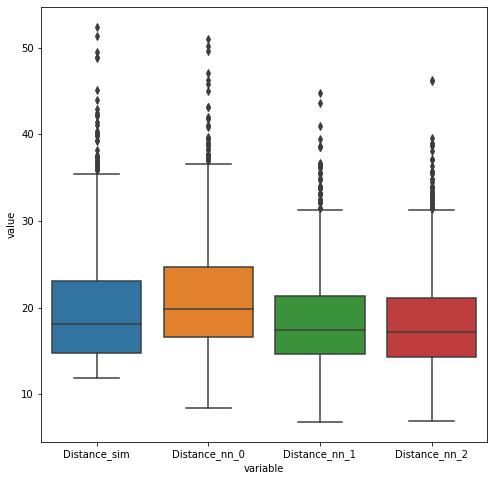

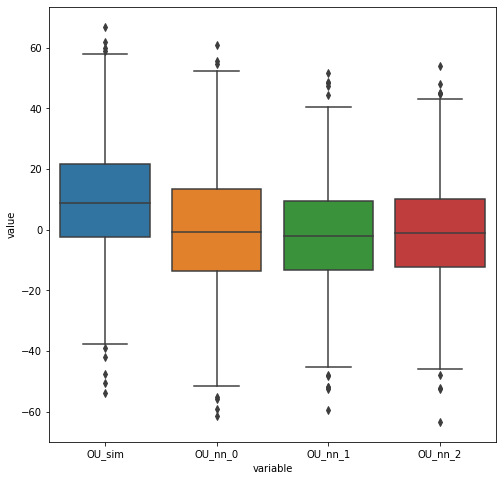

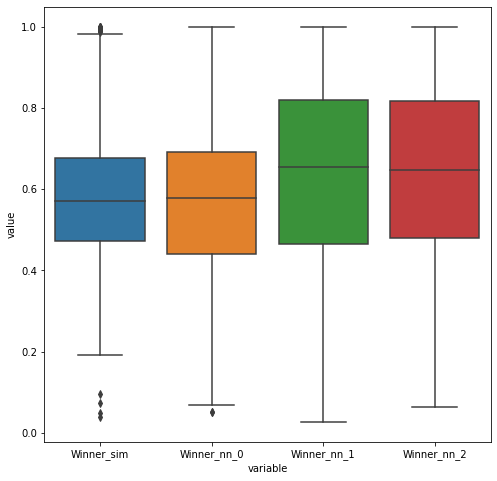

Correct_sim     0.689091
Correct_nn_0    0.647273
Correct_nn_1    0.704545
Correct_nn_2    0.719091
dtype: float64

In [ ]:
for v in list(plot_data.values())[:-1]:
    fig, ax=plt.subplots(figsize=(8,8))
    to_plot=v.melt(id_vars='Game')
    sns.boxplot(x='variable',y='value',data=to_plot)
    plt.show()
winner_accuracy = list(plot_data.values())[-1]
winner_accuracy=winner_accuracy.drop('Game',axis=1).mean()
winner_accuracy

In [ ]:
nn_list=[m1,m2, m3, m4, m5, m6]

In [51]:
with open('models/nn_732.pickle', 'wb') as handle:
    pickle.dump(m1, handle)

with open('models/nn_725.pickle', 'wb') as handle:
    pickle.dump(m2, handle)

with open('models/nn_722.pickle', 'wb') as handle:
    pickle.dump(m5, handle)